In [107]:
from functools import partial
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
import jax.random as jr
import jaxopt

# JAX Tutorial: From Zero to Newbie

This tutorial will guide you from zero JAX knowledge to a beginner level. It assumes only basic Python and some familiarity with NumPy and Matplotlib.

## The numpy API

In [108]:
# jax.numpy (jnp for friends) is the best entry point for new jax users.
# It is a lot like numpy.
a = jnp.ones((2))
b = jnp.array([1.0, 2.0])
a + b

Array([2., 3.], dtype=float32)

In [109]:
jnp.sin(a**2 + b**2) # really feels like numpy so far!

Array([ 0.9092974, -0.9589243], dtype=float32)

In [110]:
# The jax interface for random number is slighlt different from numpy for reasons that will be clear later on.
# let us stick with ordinary numpy (onp here) for now...
c = onp.random.randn((2))
# jax-numpy interoperability in action!
a + c

Array([1.6289905, 1.3184656], dtype=float32)

In [111]:
c[1] = 0  # ok, this is numpy
# a[1] = 1 # throws an error!
# jax arrays are immutable, and in-place operations are not allowed!
a.at[1].set(0.0)

Array([1., 0.], dtype=float32)

## Automatic differentiation and optimization

In [112]:
# A jax model can be as simple as a plain python function:
def linear_model(params, x):
    y = x * params[0] + params[1]
    return y

In [113]:
params_true = jnp.array([1.0, 2.0]) # true, unknown value
params_init = onp.random.randn(2,) # initial guess (initialized with ordinary numpy)

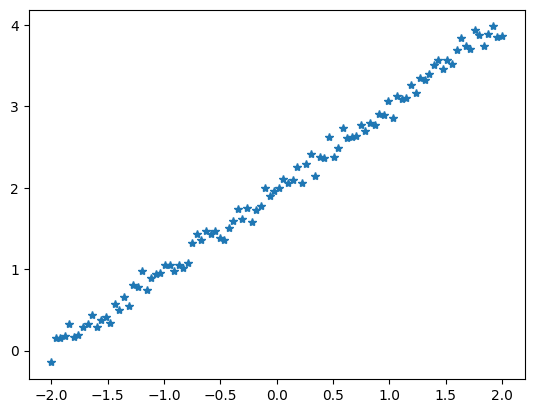

In [114]:
# Let us define some fake data
N = 100
x = onp.linspace(-2, 2, 100)
y = linear_model(params_true, x) + onp.random.randn(N) * 0.1
plt.plot(x, y, "*")

In [115]:
# Let us define the loss as a differentiable function
def loss_fn(p, y, x):
    y_hat = linear_model(p, x)
    loss = jnp.mean((y - y_hat) ** 2)
    return loss


loss_fn(params_init, y, x)

Array(2.2751539, dtype=float32)

In [116]:
# This computes the gradient of the loss!
loss_grad_fn = jax.grad(loss_fn) # wrt first argument, p
loss_grad_fn(params_init, y, x)

Array([-2.0808904, -2.4256074], dtype=float32)

In [117]:
params_opt = params_init

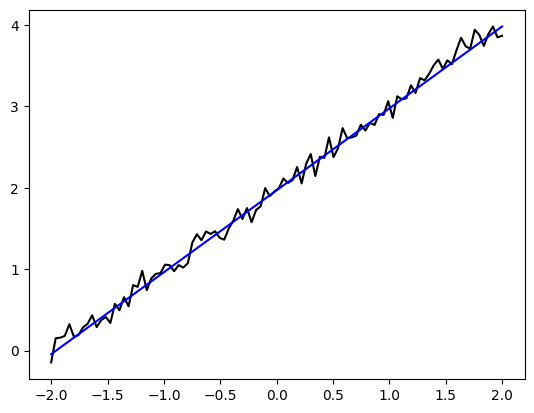

In [118]:
# We can wrap up a gradient-based optimization procedure!
# No bells & wistles!
lr = 1e-2
for _ in range(200):
    g = loss_grad_fn(params_opt, y, x)
    params_opt = params_opt - lr * g

plt.figure()
plt.plot(x, y, "k")
plt.plot(x, linear_model(params_opt, x), "b")

In [119]:
params_opt, params_true  # almost there...

(Array([1.0059787, 1.9679121], dtype=float32), Array([1., 2.], dtype=float32))

Traditional second-order solvers are also available in external libraries such as ``jaxopt``!

In [120]:
# BFGS
solver_bfgs = jaxopt.BFGS(fun=partial(loss_fn, y=y, x=x))
params_bfgs, state_bfgs = solver_bfgs.run(params_init)
params_bfgs

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 4.141374588012695 Stepsize:1.0  Decrease Error:1.5610239505767822  Curvature Error:4.141374588012695 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.4337504208087921  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.6506256461143494  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.9759384393692017  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 


Array([1.0090537, 1.989243 ], dtype=float32)

In [121]:
# Levenberg-Marquardt
def resid_fn(p, y, x):
    y_hat = linear_model(p, x)
    resid = y - y_hat
    return resid


solver_lm = jaxopt.LevenbergMarquardt(lambda p: resid_fn(p, y, x), maxiter=100)
params_lm, state_lm = solver_lm.run(params_init)
params_lm

Array([1.0090529, 1.9892411], dtype=float32)

# Parallel execution with vmap

Jax provides a powerful ``vmap`` operator to *vectorize* function execution

In [122]:
# Let us build a model that acts on a single element.
def linear_model(weight, input):
    return weight @ input


in_feat = 3
out_feat = 10

W = onp.random.randn(out_feat, in_feat)  # 10 outputs, 3 inputs
x = onp.random.randn(in_feat)
y = linear_model(W, x)

# What if we have a vector of examples?
batch_size = 32
X = onp.random.randn(batch_size, in_feat)

# In pytorch, we would end up re-writing the linear layer in a less straightforward fashion:
Y = X @ W.T # :-(
Y.shape

# In jax, we would rather harness the power of vmap!
Y_vmap = jax.vmap(linear_model, in_axes=(None, 0))(W, X) # :-)
jnp.allclose(Y, Y_vmap, rtol=1e-4) # equivalent up to some numerical difference

Array(True, dtype=bool)

In [123]:
# Here (like above), we vectorize on the second argument only (the data!)
# This makes sense when we apply the same model to different data batches
batched_linear_model = jax.vmap(linear_model, in_axes=(None, 0))
Y_vmap = batched_linear_model(W, X)

In [124]:
# This is the converse: different models (an ensemble?) acting on the same data!
W_many = onp.random.randn(batch_size, out_feat, in_feat)
many_linear_models_same_data = jax.vmap(linear_model, in_axes=(0, None))
Y_many = many_linear_models_same_data(W_many, x)
Y_many.shape

(32, 10)

In [125]:
# By default, we vectorize on all arguments. We simulate several models over several datasets in parallel!
many_linear_models = jax.vmap(linear_model)
Y_many = many_linear_models(W_many, X)

# Jax data structure: PyTrees 

In Jax, function arguments can be (nested) collection objects generically referred to as pytrees this simplifies definition of structured models such as neural networks from scratch

Example: MLP with one hidden layer, parameters in a nested python dictionary

In [126]:
# Let us implement a MLP from scratch!
nn_sizes = [3, 16, 10]  # 3 inputs, 16 hidden layers, 10 outputs

params_nn = {
    "layer0": {
        "W": onp.random.randn(nn_sizes[1], nn_sizes[0]),
        "b": onp.random.randn(nn_sizes[1]),
    },
    "layer1": {
        "W": onp.random.randn(nn_sizes[2], nn_sizes[1]),
        "b": onp.random.randn(nn_sizes[2]),
    },
}

def nn_model(p, input):
    z = jax.nn.sigmoid(p["layer0"]["W"] @ input + p["layer0"]["b"])
    out = p["layer1"]["W"] @ z + p["layer1"]["b"]
    return out

In [127]:
x = onp.random.randn(
    nn_sizes[0],
)
y_nn = nn_model(params_nn, x)
y_nn.shape

(10,)

In [128]:
# batched execution of the MLP with vmap
X = onp.random.randn(batch_size, nn_sizes[0])
Y = jax.vmap(nn_model, in_axes=(None, 0))(params_nn, X)
Y.shape

(32, 10)

In [129]:
# batched loss computation
def loss_fn(p, input, target):
    predicted = jax.vmap(nn_model, in_axes=(None, 0))(p, input)
    error = target - predicted
    return jnp.mean(error**2)

Y_true = onp.random.randn(batch_size, nn_sizes[-1]) # some fake data
loss_fn(params_nn, X, Y_true)

Array(9.656756, dtype=float32)

Jax has built-in tools for PyTree manipulation

In [130]:
params_sq = jax.tree.map(lambda x : x**2, params_nn) # all parameters squared (unary op)

In [131]:
params_sum = jax.tree.map(lambda x, y: x + y, params_nn, params_sq) # sum of two pytrees (binary op)

In [132]:
#params_flat, unflatten_pars = jax.flatten_util.ravel_pytree(params_nn) # flat vector, unflatten function

# Jax as a jit-compiled language

Jax functions can be jit-compiled for much faster execution. Common use case: compile gradient computations!

In [133]:
%%timeit -n 100
loss, grad = jax.value_and_grad(loss_fn)(params_nn, X, Y)

1.99 ms ± 29.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [134]:
grad_fn_jit = jax.jit(jax.value_and_grad(loss_fn))

In [135]:
%%timeit -n 1000
loss, grad = grad_fn_jit(params_nn, X, Y)

46.2 μs ± 9.57 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Random numbers in Jax

Native Jax random number generators always require a key to be passed explicitly

In [136]:
key = jr.key(1234)

In [137]:
jr.normal(key)

Array(-0.54019827, dtype=float32)

In [138]:
jr.normal(key, shape=(2,)) # same key=same result!

Array([ 0.43957582, -0.26563603], dtype=float32)

The Jax user is responsible of splitting the keys to generate different random numbers

In [139]:
key, subkey = jr.split(key, 2)
jr.normal(key, shape=(2,)), jr.normal(subkey, shape=(2,))

(Array([-1.2972969, -0.9846392], dtype=float32),
 Array([-1.7366334, -1.7102827], dtype=float32))

This is the price to pay for having a *pure function* interface!

In [140]:
# same arguments, different results. That's not a pure function.
onp.random.randn(2), onp.random.randn(2)

(array([-0.26274683,  0.23681197]), array([ 0.59388826, -0.78866814]))

In [141]:
# same arguments, same results. This is a pure function!
jr.normal(key, shape=(2,)), jr.normal(key, shape=(2,))

(Array([-1.2972969, -0.9846392], dtype=float32),
 Array([-1.2972969, -0.9846392], dtype=float32))

# Higher-level interfaces: flax.linen

There are many neural network libraries built upon jax.
Let us quickly explore ``flax.linen``

In [142]:
from flax import linen as nn

In [143]:
in_size = 10
out_size = 5
hidden = 16

class CustomRNNCell(nn.Module):
    hidden_size: int
    out_size: int

    def setup(self):
        self.lin1 = nn.Dense(self.hidden_size)
        self.lin2 = nn.Dense(self.out_size)

    def __call__(self, input):
        x = nn.relu(self.lin1(input))
        x = self.lin2(x)
        return x

f_xu = CustomRNNCell(hidden_size=hidden, out_size=out_size)
key, subkey = jr.split(key, 2)

# params are not part of the module!
params = f_xu.init(subkey, jnp.ones((in_size)))
params

{'params': {'lin1': {'kernel': Array([[ 0.34915778,  0.09149738,  0.08031028, -0.1144528 ,  0.317296  ,
            0.6505861 , -0.26838434,  0.16204348, -0.20969899, -0.18522389,
           -0.06305052, -0.07610493,  0.01470689, -0.19302115, -0.06943785,
           -0.15517578],
          [ 0.2830291 , -0.09197768, -0.32951352,  0.4423861 ,  0.12644179,
            0.05594965,  0.36738932, -0.3758351 , -0.03918812, -0.1170873 ,
           -0.55121595,  0.01673536, -0.11866205, -0.03521184,  0.02144702,
           -0.18217386],
          [ 0.36236632,  0.01984214, -0.3064592 , -0.05859586,  0.112603  ,
           -0.33131287,  0.13602741, -0.45689803, -0.43613708, -0.13689123,
           -0.3734352 , -0.0782427 , -0.12966101, -0.14389671,  0.16927539,
           -0.08479758],
          [ 0.3925566 ,  0.45545122,  0.05914405, -0.39626774,  0.5778542 ,
            0.31908202,  0.11089025,  0.17845038, -0.16434291, -0.4232039 ,
            0.09702438, -0.660742  , -0.04026402,  0.07749574

In [144]:
# to use the model, we pass the parameters as first argument!
f_xu.apply(params, jnp.ones(in_size))

Array([ 0.09367611, -0.74441713, -0.39785287,  0.24151626, -0.82042664],      dtype=float32)

# Scan

The jax.lax.scan transformation makes certain loop unrolling blazing fast. Roughly, it correspond to the plain Python code:


```python
def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

However, jax.lax.scan is highly optimized. My typical use case: speed up custom recurrent neural network/state-space models


\begin{align*}
 x_{k+1} &= N_f(x_k, u_k)\\
 y_k &= N_g(x_k),
\end{align*}
where $N_f$, $N_g$ are some custom-made neural networks. Here is an example

In [145]:
nx = 4
ny = 3
nu = 2
seq_len = 100

In [146]:
x0 = jnp.ones(nx) # initial state
u0 = jnp.ones(nu) # initial input (just to simulate the first step)
u = jnp.ones((seq_len, nu)) # input sequence

In [147]:
class CustomRNNCell(nn.Module):
    nx: int # state size
    ny: int # output size 
    hidden_size: int

    def setup(self):
        # blocks of f(x, u)
        self.fxu_lin1 = nn.Dense(self.hidden_size)
        self.fxu_lin2 = nn.Dense(self.nx)
        # blocks of g(x)
        self.gx_lin1 = nn.Dense(self.hidden_size)
        self.gx_lin2 = nn.Dense(self.ny)

    def __call__(self, x, u):
        
        x_new = nn.relu(self.fxu_lin1(jnp.concatenate([x, u], axis=-1)))
        x_new = self.fxu_lin2(x_new)

        y = nn.relu(self.gx_lin1(x))
        y = self.gx_lin2(y)
        return x_new, y


In [148]:
rnn_cell = CustomRNNCell(nx, ny, hidden_size=32)
key, subkey = jr.split(key, 2)
rnn_params = rnn_cell.init(subkey, x0, u0)

In [149]:
# simulate the first step
x1, y1 = rnn_cell.apply(rnn_params, x0, u0)
x1, y1

(Array([ 0.01072216, -0.00196731, -0.59016675,  0.8015732 ], dtype=float32),
 Array([ 0.94773614, -0.47453153,  1.0662725 ], dtype=float32))

In [150]:
# simulate the sequence
fg_func = lambda x, u: rnn_cell.apply(rnn_params, x, u) 
xf, y = jax.lax.scan(fg_func, x0, u)
xf.shape, y.shape

((4,), (100, 3))

In [151]:
# a minimal interface for the RNN
def simulate_rnn(params, x0, u):
    fg_func = lambda x, u: rnn_cell.apply(params, x, u)
    xf, y = jax.lax.scan(fg_func, x0, u)
    return xf, y

xf, y = simulate_rnn(rnn_params, x0, u)

All jax transformations are composable. You can *batchify* the `simulate_rnn` function above and make it super efficient with jax.jit!